# CycleGAN for Gender Swap


#### Directory structure:
- **data/** contains the datasets.
    - **data/malefemale/{train_A, train_B}/** contains training images for classes A and B.
    - **data/malefemale/{test_A, test_B}/** contains testing images that are not used during training. These are useful to evaluate the generalization of the model to new data.

#### Example data
We provide a small example dataset with images of male and female faces. During training the CycleGAN learns to switch the genre of the faces. This dataset is small enough that the training can be run in under 30 mins with a GPU. New datasets can be added by placing them in the **data/** folder, and can be selected by setting the `image_folder` variable below.

#### Loss Functions and their Interpretation during Training
-  The top row shows, from left to right, the original image $A$, the translated image $B'=G_{AB}(A)$ and the recovered image $A'' = G_{BA}(B') = G_{BA}(G_{AB}(A))$. The bottom row shows similar images for the other domain: $B$, $A'$, $B''$. Here is an exmaple form the middle of training:

    <img src="https://github.com/brainhack101/IntroDL/blob/master/notebooks/2019/Eklund/notebook_images/tmp.png?raw=1">

    The adversarial losses push the middle image in both rows to look realistic. On the other hand, the cycle consistenxy losses force the left (original) and right (reconstructed) images to be similar.


## Setting Up the Environment

### Installing the Requirements and Importing the Libraries

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git progress
from keras.layers import Layer, Input, Dropout, Conv2D, Activation, add, UpSampling2D, \
    Conv2DTranspose, Flatten
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Network
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from progress.bar import Bar
import datetime
import time
import json
import csv
import sys
import os

import keras.backend as K
import tensorflow as tf

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-j8a2zpf6
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-j8a2zpf6
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=9a77b07d5a6265050bd29a11802d47d1e988e9b3f7fb6fd5eb07cf086e186e70
  Stored in directory: /tmp/pip-ephem-wheel-cache-lotccwaa/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


Using TensorFlow backend.


### Miscellaneous Functions

In [ ]:
from keras.layers import Layer
from keras_contrib.layers.normalization.instancenormalization import InputSpec

import numpy as np
import matplotlib.image as mpimg
from progress.bar import Bar
import datetime
import time
import json
import csv
import os

import keras.backend as K
import tensorflow as tf


class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')


class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            if len(image.shape) == 3:
                image = image[np.newaxis, :, :, :]

            if self.num_imgs < self.pool_size:  # fill up the image pool
                self.num_imgs = self.num_imgs + 1
                if len(self.images) == 0:
                    self.images = image
                else:
                    self.images = np.vstack((self.images, image))

                if len(return_images) == 0:
                    return_images = image
                else:
                    return_images = np.vstack((return_images, image))

            else:  # 50% chance that we replace an old synthetic image
                p = np.random.rand()
                if p > 0.5:
                    random_id = np.random.randint(0, self.pool_size)
                    tmp = self.images[random_id, :, :, :]
                    tmp = tmp[np.newaxis, :, :, :]
                    self.images[random_id, :, :, :] = image[0, :, :, :]
                    if len(return_images) == 0:
                        return_images = tmp
                    else:
                        return_images = np.vstack((return_images, tmp))
                else:
                    if len(return_images) == 0:
                        return_images = image
                    else:
                        return_images = np.vstack((return_images, image))

        return return_images


def load_data(subfolder='', generator=False):
    def create_image_array(image_list, image_path, image_size, nr_of_channels):
        bar = Bar('Loading...', max=len(image_list))

        # Define image array
        image_array = np.empty((len(image_list),) + (image_size) + (nr_of_channels,))
        i = 0
        for image_name in image_list:
            # If file is image...
            if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
                # Load image and convert into np.array
                image = mpimg.imread(os.path.join(image_path, image_name))  # Normalized to [0,1]
                # image = np.array(Image.open(os.path.join(image_path, image_name)))

                # Add third dimension if image is 2D
                if nr_of_channels == 1:  # Gray scale image -> MR image
                    image = image[:, :, np.newaxis]

                # Normalize image with (max 8 bit value - 1)
                image = image * 2 - 1
                # image = image / 127.5 - 1

                # Add image to array
                image_array[i, :, :, :] = image
                i += 1
                bar.next()
        bar.finish()

        return image_array

    # Image paths
    trainA_path = os.path.join('data', subfolder, 'trainA')
    trainB_path = os.path.join('data', subfolder, 'trainB')
    testA_path = os.path.join('data', subfolder, 'testA')
    testB_path = os.path.join('data', subfolder, 'testB')

    # Image file names
    trainA_image_names = sorted(os.listdir(trainA_path))
    trainB_image_names = sorted(os.listdir(trainB_path))
    testA_image_names = sorted(os.listdir(testA_path))
    testB_image_names = sorted(os.listdir(testB_path))

    # Examine one image to get size and number of channels
    im_test = mpimg.imread(os.path.join(trainA_path, trainA_image_names[0]))
    # im_test = np.array(Image.open(os.path.join(trainA_path, trainA_image_names[0])))

    if len(im_test.shape) == 2:
        image_size = im_test.shape
        nr_of_channels = 1
    else:
        image_size = im_test.shape[0:-1]
        nr_of_channels = im_test.shape[-1]

    trainA_images = create_image_array(trainA_image_names, trainA_path, image_size, nr_of_channels)
    trainB_images = create_image_array(trainB_image_names, trainB_path, image_size, nr_of_channels)
    testA_images = create_image_array(testA_image_names, testA_path, image_size, nr_of_channels)
    testB_images = create_image_array(testB_image_names, testB_path, image_size, nr_of_channels)

    return {"image_size": image_size, "nr_of_channels": nr_of_channels,
            "trainA_images": trainA_images, "trainB_images": trainB_images,
            "testA_images": testA_images, "testB_images": testB_images,
            "trainA_image_names": trainA_image_names,
            "trainB_image_names": trainB_image_names,
            "testA_image_names": testA_image_names,
            "testB_image_names": testB_image_names}


def write_metadata_to_JSON(model, opt):
    # Save meta_data
    data = {}
    data['meta_data'] = []
    data['meta_data'].append({
        'img shape: height,width,channels': opt['img_shape'],
        'batch size': opt['batch_size'],
        'save training img interval': opt['save_training_img_interval'],
        'normalization function': str(model['normalization']),
        'lambda_ABA': opt['lambda_ABA'],
        'lambda_BAB': opt['lambda_BAB'],
        'lambda_adversarial': opt['lambda_adversarial'],
        'learning_rate_D': opt['learning_rate_D'],
        'learning rate G': opt['learning_rate_G'],
        'epochs': opt['epochs'],
        'use linear decay on learning rates': opt['use_linear_decay'],
        'epoch where learning rate linear decay is initialized (if use_linear_decay)': opt['decay_epoch'],
        'generator iterations': opt['generator_iterations'],
        'discriminator iterations': opt['discriminator_iterations'],
        'use patchGan in discriminator': opt['use_patchgan'],
        'beta 1': opt['beta_1'],
        'beta 2': opt['beta_2'],
        'REAL_LABEL': opt['REAL_LABEL'],
        'number of A train examples': len(opt['A_train']),
        'number of B train examples': len(opt['B_train']),
        'number of A test examples': len(opt['A_test']),
        'number of B test examples': len(opt['B_test']),
        'discriminator sigmoid': opt['discriminator_sigmoid'],
        'resize convolution': opt['use_resize_convolution'],
    })

    with open('{}/meta_data.json'.format(opt['out_dir']), 'w') as outfile:
        json.dump(data, outfile, sort_keys=True)


def write_loss_data_to_file(opt, history):
    keys = sorted(history.keys())
    with open('images/{}/loss_output.csv'.format(opt['date_time']), 'w') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        writer.writerow(keys)
        writer.writerows(zip(*[history[key] for key in keys]))


def join_and_save(opt, images, save_path):
    # Join images
    image = np.hstack(images)

    # Save images
    if opt['channels'] == 1:
        image = image[:, :, 0]

    mpimg.imsave(save_path, image, vmin=-1, vmax=1, cmap='gray')


def save_epoch_images(model, opt, epoch, num_saved_images=1):
    # Save training images
    nr_train_im_A = opt['A_train'].shape[0]
    nr_train_im_B = opt['B_train'].shape[0]

    rand_ind_A = np.random.randint(nr_train_im_A)
    rand_ind_B = np.random.randint(nr_train_im_B)

    real_image_A = opt['A_train'][rand_ind_A]
    real_image_B = opt['B_train'][rand_ind_B]
    synthetic_image_B = model['G_A2B'].predict(real_image_A[np.newaxis])[0]
    synthetic_image_A = model['G_B2A'].predict(real_image_B[np.newaxis])[0]
    reconstructed_image_A = model['G_B2A'].predict(synthetic_image_B[np.newaxis])[0]
    reconstructed_image_B = model['G_A2B'].predict(synthetic_image_A[np.newaxis])[0]

    save_path_A = '{}/train_A/epoch{}.png'.format(opt['out_dir'], epoch)
    save_path_B = '{}/train_B/epoch{}.png'.format(opt['out_dir'], epoch)
    if opt['paired_data']:
        real_image_Ab = opt['B_train'][rand_ind_A]
        real_image_Ba = opt['A_train'][rand_ind_B]
        join_and_save(opt, (real_image_Ab, real_image_A, synthetic_image_B, reconstructed_image_A), save_path_A)
        join_and_save(opt, (real_image_Ba, real_image_B, synthetic_image_A, reconstructed_image_B), save_path_B)
    else:
        join_and_save(opt, (real_image_A, synthetic_image_B, reconstructed_image_A), save_path_A)
        join_and_save(opt, (real_image_B, synthetic_image_A, reconstructed_image_B), save_path_B)

    # Save test images
    real_image_A = opt['A_test'][0]
    real_image_B = opt['B_test'][0]
    synthetic_image_B = model['G_A2B'].predict(real_image_A[np.newaxis])[0]
    synthetic_image_A = model['G_B2A'].predict(real_image_B[np.newaxis])[0]
    reconstructed_image_A = model['G_B2A'].predict(synthetic_image_B[np.newaxis])[0]
    reconstructed_image_B = model['G_A2B'].predict(synthetic_image_A[np.newaxis])[0]

    save_path_A = '{}/test_A/epoch{}.png'.format(opt['out_dir'], epoch)
    save_path_B = '{}/test_B/epoch{}.png'.format(opt['out_dir'], epoch)
    if opt['paired_data']:
        real_image_Ab = opt['B_test'][0]
        real_image_Ba = opt['A_test'][0]
        join_and_save(opt, (real_image_Ab, real_image_A, synthetic_image_B, reconstructed_image_A), save_path_A)
        join_and_save(opt, (real_image_Ba, real_image_B, synthetic_image_A, reconstructed_image_B), save_path_B)
    else:
        join_and_save(opt, (real_image_A, synthetic_image_B, reconstructed_image_A), save_path_A)
        join_and_save(opt, (real_image_B, synthetic_image_A, reconstructed_image_B), save_path_B)


def save_tmp_images(model, opt, real_image_A, real_image_B, synthetic_image_A, synthetic_image_B):
    try:
        reconstructed_image_A = model['G_B2A'].predict(synthetic_image_B[np.newaxis])[0]
        reconstructed_image_B = model['G_A2B'].predict(synthetic_image_A[np.newaxis])[0]

        real_images = np.vstack((real_image_A, real_image_B))
        synthetic_images = np.vstack((synthetic_image_B, synthetic_image_A))
        reconstructed_images = np.vstack((reconstructed_image_A, reconstructed_image_B))

        save_path = '{}/tmp.png'.format(opt['out_dir'])
        join_and_save(opt, (real_images, synthetic_images, reconstructed_images), save_path)
    except: # Ignore if file is open
        pass


def get_lr_linear_decay_rate(opt):
    # Calculate decay rates
    # max_nr_images = max(len(opt['A_train']), len(opt['B_train']))

    nr_train_im_A = opt['A_train'].shape[0]
    nr_train_im_B = opt['B_train'].shape[0]
    nr_batches_per_epoch = int(np.ceil(np.max((nr_train_im_A, nr_train_im_B)) / opt['batch_size']))

    updates_per_epoch_D = 2 * nr_batches_per_epoch
    updates_per_epoch_G = nr_batches_per_epoch
    nr_decay_updates_D = (opt['epochs'] - opt['decay_epoch'] + 1) * updates_per_epoch_D
    nr_decay_updates_G = (opt['epochs'] - opt['decay_epoch'] + 1) * updates_per_epoch_G
    decay_D = opt['learning_rate_D'] / nr_decay_updates_D
    decay_G = opt['learning_rate_G'] / nr_decay_updates_G

    return decay_D, decay_G


def update_lr(model, decay):
    new_lr = K.get_value(model.optimizer.lr) - decay
    if new_lr < 0:
        new_lr = 0
    # print(K.get_value(model.optimizer.lr))
    K.set_value(model.optimizer.lr, new_lr)

def print_ETA(opt, start_time, epoch, nr_im_per_epoch, loop_index):
    passed_time = time.time() - start_time

    iterations_so_far = ((epoch - 1) * nr_im_per_epoch + loop_index) / opt['batch_size']
    iterations_total = opt['epochs'] * nr_im_per_epoch / opt['batch_size']
    iterations_left = iterations_total - iterations_so_far
    eta = round(passed_time / (iterations_so_far + 1e-5) * iterations_left)

    passed_time_string = str(datetime.timedelta(seconds=round(passed_time)))
    eta_string = str(datetime.timedelta(seconds=eta))
    print('Elapsed time', passed_time_string, ': ETA in', eta_string)
    
def save_model(opt, model, epoch):
    # Create folder to save model architecture and weights
    directory = os.path.join('saved_models', opt['date_time'])
    if not os.path.exists(directory):
        os.makedirs(directory)

    weights_path = '{}/{}_weights_epoch_{}.hdf5'.format(directory, model.name, epoch)
    model.save_weights(weights_path)
    model_path = '{}/{}_model_epoch_{}.json'.format(directory, model.name, epoch)
    model.save_weights(model_path)
    json_string = model.to_json()
    with open(model_path, 'w') as outfile:
        json.dump(json_string, outfile)
    print('{} has been saved in saved_models/{}/'.format(model.name, opt['date_time']))

### Unzip and Load Data for training


In [ ]:
!wget -O data.zip https://www.dropbox.com/s/bnxfjuldt2jyu6a/data.zip?dl=0
!unzip -uo data.zip
image_folder = 'malefemale'
data = load_data(subfolder=image_folder)

--2019-12-12 09:45:57--  https://www.dropbox.com/s/bnxfjuldt2jyu6a/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/bnxfjuldt2jyu6a/data.zip [following]
--2019-12-12 09:45:58--  https://www.dropbox.com/s/raw/bnxfjuldt2jyu6a/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc881e98b38c8d04e67b2c6857f.dl.dropboxusercontent.com/cd/0/inline/AuGk1Z_s9D2SA1EHqzapUPpuLMuE61yM12XV2KhwaXghaTBI5Kx-jzBlJvJdu9LtU9Gx_ZPoTwtPO6jdOTGhcWVuHePYRO2cH6a1qGe1YbleprWdL8ksrCCof_ONXGImgQQ/file# [following]
--2019-12-12 09:45:58--  https://ucc881e98b38c8d04e67b2c6857f.dl.dropboxusercontent.com/cd/0/inline/AuGk1Z_s9D2SA1EHqzapUPpuLMuE61yM12XV2KhwaXghaTBI5Kx-jzBlJvJdu9LtU9Gx_ZPoTwtPO6jdOTGhcWVuHePYRO2cH6a1qGe1YbleprWdL8ksrC

## Parameters


### Model parameters

In our case, we use 90 training images for each of the two classes.

In [ ]:
opt = {}

# Data
opt['channels'] = data["nr_of_channels"]
opt['img_shape'] = data["image_size"] + (opt['channels'],)
print('Image shape: ', opt['img_shape'])

opt['A_train'] = data["trainA_images"]
opt['B_train'] = data["trainB_images"]
opt['A_test'] = data["testA_images"]
opt['B_test'] = data["testB_images"]
opt['testA_image_names'] = data["testA_image_names"]
opt['testB_image_names'] = data["testB_image_names"]
opt['paired_data'] = False

Image shape:  (64, 64, 1)


### Training parameters
- `lambda_ABA` and `lambda_BAB` set the importance of the cycle consistency losses in relation to the adversarial loss `lambda_adversarial`
- `learning_rate_D` and `learning_rate_G` are the learning rates for the discriminators and generators respectively.
- `generator_iterations` and `discriminator_iterations` represent how many times the generators or discriminators will be trained on every batch of images. This is very useful to keep the training of both systems balanced. In this case the discriminators become successful faster than the generators, so we account for this by training the generators 3 times on every batch of images.
- `synthetic_pool_size` sets the size of the image pool used for training the discriminators. The image pool has a certain probability of returning a synthetic image from previous iterations, thus forcing the discriminator to have a certain "memory". More information on this method can be found in [this paper](https://arxiv.org/abs/1612.07828).
- `beta_1` and `beta_2` are paremeters of the [Adam](https://arxiv.org/abs/1412.6980) optimizers used on the generators and discriminators.
- `batch_size` determines the number of images used for each update of the network weights. Due to the significant memory requirements of CycleGAN it is difficult to use a large batch size. For the small example dataset values between 1-30 may be possible.
- `epochs` sets the number of training epochs. Each epoch goes through all the training images once. The number of epochs necessary to train a model is therefore dependent on both the number of training images available and the batch size.

In [ ]:
# Training parameters
opt['lambda_ABA'] = 10.0  # Cyclic loss weight A_2_B
opt['lambda_BAB'] = 10.0  # Cyclic loss weight B_2_A
opt['lambda_adversarial'] = 1.0  # Weight for loss from discriminator guess on synthetic images
opt['learning_rate_D'] = 2e-4
opt['learning_rate_G'] = 2e-4
opt['generator_iterations'] = 3  # Number of generator training iterations in each training loop
opt['discriminator_iterations'] = 1  # Number of discriminator training iterations in each training loop
opt['synthetic_pool_size'] = 50  # Size of image pools used for training the discriminators
opt['beta_1'] = 0.5  # Adam parameter
opt['beta_2'] = 0.999  # Adam parameter
opt['batch_size'] = 10  # Number of images per batch
opt['epochs'] = 200  # Choose multiples of 20 since the models are saved each 20th epoch

### Miscellaneous Parameters

In [ ]:
# Output parameters
opt['save_models'] = True  # Save or not the generator and discriminator models
opt['save_training_img'] = True  # Save or not example training results or only tmp.png
opt['save_training_img_interval'] = 1  # Number of epoch between saves of intermediate training results
opt['self.tmp_img_update_frequency'] = 3  # Number of batches between updates of tmp.png

### Architecture parameters
- `use_instance_normalization` is supposed to allow the selection of instance normalization or batch normalization layes. 
- `use_dropout` and `use_bias` allows setting droupout layers in the generators and whether to use a bias term in the various convolutional layer in the genrators and discriminators.
- `use_linear_decay` applies linear decay on the learning rates of the generators and discriminators,   `decay_epoch`
- `use_patchgan` determines whether the discriminator evaluates the "realness" of images on a patch basis or on the whole. More information on PatchGAN can be found in [this paper](https://arxiv.org/abs/1611.07004).
- `use_resize_convolution` provides two ways to perfrom the upsampling in the generator, with significant differences in the results. More information can be found in [this article](https://distill.pub/2016/deconv-checkerboard/). Each has its advantages, and we have managed to get successful result with both methods
- `use_discriminator sigmoid` adds a sigmoid activation at the end of the discrimintator, forcing its output to the (0-1) range.

In [ ]:
# Architecture parameters
opt['use_instance_normalization'] = True  # Use instance normalization or batch normalization
opt['use_dropout'] = False  # Dropout in residual blocks
opt['use_bias'] = True  # Use bias
opt['use_linear_decay'] = True  # Linear decay of learning rate, for both discriminators and generators
opt['decay_epoch'] = 101  # The epoch where the linear decay of the learning rates start
opt['use_patchgan'] = True  # PatchGAN - if false the discriminator learning rate should be decreased
opt['use_resize_convolution'] = False  # Resize convolution - instead of transpose convolution in deconvolution layers (uk) - can reduce checkerboard artifacts but the blurring might affect the cycle-consistency
opt['discriminator_sigmoid'] = True  # Add a final sigmoid activation to the discriminator
# Tweaks
opt['REAL_LABEL'] = 1.0  # Use e.g. 0.9 to avoid training the discriminators to zero loss

## Model architecture

### Layer blocks
These are the individual layer blocks that are used to build the generators and discriminator. More information can be found in the appendix of the [CycleGAN paper](https://arxiv.org/abs/1703.10593).

In [ ]:
# Discriminator layers
def ck(model, opt, x, k, use_normalization, use_bias):
    x = Conv2D(filters=k, kernel_size=4, strides=2, padding='same', use_bias=use_bias)(x)
    if use_normalization:
        x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# First generator layer
def c7Ak(model, opt, x, k):
    x = Conv2D(filters=k, kernel_size=7, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Downsampling
def dk(model, opt, x, k):  # Should have reflection padding
    x = Conv2D(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

# Residual block
def Rk(model, opt, x0):
    k = int(x0.shape[-1])

    # First layer
    x = ReflectionPadding2D((1,1))(x0)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)

    if opt['use_dropout']:
        x = Dropout(0.5)(x)

    # Second layer
    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    # Merge
    x = add([x, x0])

    return x

# Upsampling
def uk(model, opt, x, k):
    # (up sampling followed by 1x1 convolution <=> fractional-strided 1/2)
    if opt['use_resize_convolution']:
        x = UpSampling2D(size=(2, 2))(x)  # Nearest neighbor upsampling
        x = ReflectionPadding2D((1, 1))(x)
        x = Conv2D(filters=k, kernel_size=3, strides=1, padding='valid', use_bias=opt['use_bias'])(x)
    else:
        x = Conv2DTranspose(filters=k, kernel_size=3, strides=2, padding='same', use_bias=opt['use_bias'])(x)  # this matches fractionally stided with stride 1/2
    x = model['normalization'](axis=3, center=True, epsilon=1e-5)(x, training=True)
    x = Activation('relu')(x)
    return x

#### Architecture functions

In [ ]:
def build_discriminator(model, opt, name=None):
    # Input
    input_img = Input(shape=opt['img_shape'])

    # Layers 1-4
    x = ck(model, opt, input_img, 64, False, True) #  Instance normalization is not used for this layer)
    x = ck(model, opt, x, 128, True, opt['use_bias'])
    x = ck(model, opt, x, 256, True, opt['use_bias'])
    x = ck(model, opt, x, 512, True, opt['use_bias'])

    # Layer 5: Output
    if opt['use_patchgan']:
        x = Conv2D(filters=1, kernel_size=4, strides=1, padding='same', use_bias=True)(x)
    else:
        x = Flatten()(x)
        x = Dense(1)(x)

    if opt['discriminator_sigmoid']:
        x = Activation('sigmoid')(x)

    return Model(inputs=input_img, outputs=x, name=name)

def build_generator(model, opt, name=None):
    # Layer 1: Input
    input_img = Input(shape=opt['img_shape'])
    x = ReflectionPadding2D((3, 3))(input_img)
    x = c7Ak(model, opt, x, 32)

    # Layer 2-3: Downsampling
    x = dk(model, opt, x, 64)
    x = dk(model, opt, x, 128)

    # Layers 4-12: Residual blocks
    for _ in range(4, 13):
        x = Rk(model, opt, x)

    # Layer 13:14: Upsampling
    x = uk(model, opt, x, 64)
    x = uk(model, opt, x, 32)

    # Layer 15: Output
    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(opt['channels'], kernel_size=7, strides=1, padding='valid', use_bias=True)(x)
    x = Activation('tanh')(x)

    return Model(inputs=input_img, outputs=x, name=name)

### Loss functions
The discriminators use MSE loss. The generators use MSE for the adversarial losses and MAE for the cycle consistency losses.

In [ ]:
# Mean squared error
def mse(y_true, y_pred):
    loss = tf.reduce_mean(tf.squared_difference(y_pred, y_true))
    return loss

# Mean absolute error
def mae(y_true, y_pred):
    loss = tf.reduce_mean(tf.abs(y_pred - y_true))
    return loss

## Build CycleGAN model

In [ ]:
model = {}

# Normalization
model['normalization'] = InstanceNormalization

# Optimizers
model['opt_D'] = Adam(opt['learning_rate_D'], opt['beta_1'], opt['beta_2'])
model['opt_G'] = Adam(opt['learning_rate_G'], opt['beta_1'], opt['beta_2'])

# Build discriminators
D_A = build_discriminator(model, opt, name='D_A')
D_B = build_discriminator(model, opt, name='D_B')

# Define discriminator models
image_A = Input(shape=opt['img_shape'])
image_B = Input(shape=opt['img_shape'])
guess_A = D_A(image_A)
guess_B = D_B(image_B)
model['D_A'] = Model(inputs=image_A, outputs=guess_A, name='D_A_model')
model['D_B'] = Model(inputs=image_B, outputs=guess_B, name='D_B_model')

# Compile discriminator models
loss_weights_D = [0.5]  # 0.5 since we train on real and synthetic images
model['D_A'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)
model['D_B'].compile(optimizer=model['opt_D'],
                 loss=mse,
                 loss_weights=loss_weights_D)

# Use containers to make a static copy of discriminators, used when training the generators
model['D_A_static'] = Network(inputs=image_A, outputs=guess_A, name='D_A_static_model')
model['D_B_static'] = Network(inputs=image_B, outputs=guess_B, name='D_B_static_model')

# Do not update discriminator weights during generator training
model['D_A_static'].trainable = False
model['D_B_static'].trainable = False

# Build generators
model['G_A2B'] = build_generator(model, opt, name='G_A2B_model')
model['G_B2A'] = build_generator(model, opt, name='G_B2A_model')

# Define full CycleGAN model, used for training the generators
real_A = Input(shape=opt['img_shape'], name='real_A')
real_B = Input(shape=opt['img_shape'], name='real_B')
synthetic_B = model['G_A2B'](real_A)
synthetic_A = model['G_B2A'](real_B)
dB_guess_synthetic = model['D_B_static'](synthetic_B)
dA_guess_synthetic = model['D_A_static'](synthetic_A)
reconstructed_A = model['G_B2A'](synthetic_B)
reconstructed_B = model['G_A2B'](synthetic_A)

# Compile full CycleGAN model
model_outputs = [reconstructed_A, reconstructed_B,
                 dB_guess_synthetic, dA_guess_synthetic]
compile_losses = [mae, mae,
                  mse, mse]
compile_weights = [opt['lambda_ABA'], opt['lambda_BAB'],
                   opt['lambda_adversarial'], opt['lambda_adversarial']]

model['G_model'] = Model(inputs=[real_A, real_B],
                     outputs=model_outputs,
                     name='G_model')

model['G_model'].compile(optimizer=model['opt_G'],
                     loss=compile_losses,
                     loss_weights=compile_weights)

### Folders and configuration

In [ ]:
opt['date_time'] = time.strftime('%Y%m%d-%H%M%S', time.localtime()) + '-' + image_folder

# Output folder for run data and images
opt['out_dir'] = os.path.join('images', opt['date_time'])
if not os.path.exists(opt['out_dir']):
    os.makedirs(opt['out_dir'])

# Output folder for saved models
if opt['save_models']:
    opt['model_out_dir'] = os.path.join('saved_models', opt['date_time'])
    if not os.path.exists(opt['model_out_dir']):
        os.makedirs(opt['model_out_dir'])

write_metadata_to_JSON(model, opt)

# Don't pre-allocate GPU memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

## Training function

Problems with training GANS:

1) Oscillations - The output may change very Drastically.

2) Mode Collapse - The Generator produces only one or a few types of output.

3) Diminished gradient: the discriminator gets too successful that the generator gradient vanishes and learns nothing and vice versa.


In [ ]:
def train(model, opt):

    def run_training_batch(flag = True):

        # ======= Discriminator training ======
        # Generate batch of synthetic images
        synthetic_images_B = model['G_A2B'].predict(real_images_A)
        synthetic_images_A = model['G_B2A'].predict(real_images_B)
        synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
        synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)

        # Train discriminators on batch
        D_loss = []
        for _ in range(opt['discriminator_iterations']):
            D_A_loss_real = model['D_A'].train_on_batch(x=real_images_A, y=ones)
            D_B_loss_real = model['D_B'].train_on_batch(x=real_images_B, y=ones)
            D_A_loss_synthetic = model['D_A'].train_on_batch(x=synthetic_images_A, y=zeros)
            D_B_loss_synthetic = model['D_B'].train_on_batch(x=synthetic_images_B, y=zeros)
            D_A_loss = D_A_loss_real + D_A_loss_synthetic
            D_B_loss = D_B_loss_real + D_B_loss_synthetic
            D_loss.append(D_A_loss + D_B_loss)

        # ======= Generator training ==========
        target_data = [real_images_A, real_images_B, ones, ones]  # Reconstructed images need to match originals, discriminators need to predict ones

        # Train generators on batch
        G_loss = []
        for _ in range(opt['generator_iterations']):
            G_loss.append(model['G_model'].train_on_batch(
                x=[real_images_A, real_images_B], y=target_data))

        # =====================================

        # Update learning rates
        if opt['use_linear_decay'] and epoch >= opt['decay_epoch']:
            update_lr(model['D_A'], decay_D)
            update_lr(model['D_B'], decay_D)
            update_lr(model['G_model'], decay_G)

        # Store training losses
        D_A_losses.append(D_A_loss)
        D_B_losses.append(D_B_loss)
        D_losses.append(D_loss[-1])

        ABA_reconstruction_loss = G_loss[-1][1]
        BAB_reconstruction_loss = G_loss[-1][2]
        reconstruction_loss = ABA_reconstruction_loss + BAB_reconstruction_loss
        G_AB_adversarial_loss = G_loss[-1][3]
        G_BA_adversarial_loss = G_loss[-1][4]

        ABA_reconstruction_losses.append(ABA_reconstruction_loss)
        BAB_reconstruction_losses.append(BAB_reconstruction_loss)
        reconstruction_losses.append(reconstruction_loss)
        G_AB_adversarial_losses.append(G_AB_adversarial_loss)
        G_BA_adversarial_losses.append(G_BA_adversarial_loss)
        G_losses.append(G_loss[-1][0])

        if flag == True:
          # Print training status
          print('\n')
          print('Epoch ---------------------', epoch, '/', opt['epochs'])
          if opt['discriminator_iterations'] > 1:
              print('  Discriminator losses:')
              for i in range(opt['discriminator_iterations']):
                  print('D_loss', D_loss[i])
          if opt['generator_iterations'] > 1:
              print('  Generator losses:')
              for i in range(opt['generator_iterations']):
                  print('G_loss', G_loss[i])
          print('  Summary:')
          print('D_lr:', K.get_value(model['D_A'].optimizer.lr))
          print('G_lr', K.get_value(model['G_model'].optimizer.lr))
          print('D_loss: ', D_loss[-1])
          print('G_loss: ', G_loss[-1][0])
          print('reconstruction_loss: ', reconstruction_loss)
          print_ETA(opt, start_time, epoch, nr_im_per_epoch, loop_index)
          sys.stdout.flush()

        if loop_index % 3*opt['batch_size'] == 0:
            # Save temporary images continously
            save_tmp_images(model, opt, real_images_A[0], real_images_B[0],
                                 synthetic_images_A[0], synthetic_images_B[0])

    # ======================================================================
    # Begin training
    # ======================================================================
    if opt['save_training_img'] and not os.path.exists(os.path.join(opt['out_dir'], 'train_A')):
        os.makedirs(os.path.join(opt['out_dir'], 'train_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'train_B'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_A'))
        os.makedirs(os.path.join(opt['out_dir'], 'test_B'))

    D_A_losses = []
    D_B_losses = []
    D_losses = []

    ABA_reconstruction_losses = []
    BAB_reconstruction_losses = []
    reconstruction_losses = []
    G_AB_adversarial_losses = []
    G_BA_adversarial_losses = []
    G_losses = []

    # Image pools used to update the discriminators
    synthetic_pool_A = ImagePool(opt['synthetic_pool_size'])
    synthetic_pool_B = ImagePool(opt['synthetic_pool_size'])

    # Labels used for discriminator training
    label_shape = (opt['batch_size'],) + model['D_A'].output_shape[1:]
    ones = np.ones(shape=label_shape) * opt['REAL_LABEL']
    zeros = ones * 0

    # Linear learning rate decay
    if opt['use_linear_decay']:
        decay_D, decay_G = get_lr_linear_decay_rate(opt)

    nr_train_im_A = opt['A_train'].shape[0]
    nr_train_im_B = opt['B_train'].shape[0]
    nr_im_per_epoch = int(np.ceil(np.max((nr_train_im_A, nr_train_im_B)) / opt['batch_size']) * opt['batch_size'])

    # Start stopwatch for ETAs
    start_time = time.time()
    timer_started = False

    for epoch in range(1, opt['epochs'] + 1):
        # random_order_A = np.random.randint(nr_train_im_A, size=nr_im_per_epoch)
        # random_order_B = np.random.randint(nr_train_im_B, size=nr_im_per_epoch)

        random_order_A = np.concatenate((np.random.permutation(nr_train_im_A),
                                         np.random.randint(nr_train_im_A, size=nr_im_per_epoch - nr_train_im_A)))
        random_order_B = np.concatenate((np.random.permutation(nr_train_im_B),
                                         np.random.randint(nr_train_im_B, size=nr_im_per_epoch - nr_train_im_B)))

        # Train on image batch
        for loop_index in range(0, nr_im_per_epoch, opt['batch_size']):
            indices_A = random_order_A[loop_index:loop_index + opt['batch_size']]
            indices_B = random_order_B[loop_index:loop_index + opt['batch_size']]
            if loop_index ==0:
              flag = True
            else:
              flag = False
            real_images_A = opt['A_train'][indices_A]
            real_images_B = opt['B_train'][indices_B]

            # Train on image batch
            run_training_batch(flag)

            # Start timer after first (slow) iteration has finished
            if not timer_started:
                start_time = time.time()
                timer_started = True
        print('\n', '\n', '-------------------------Epoch', epoch, '-------------------------', '\n', '\n')

        # Save training images
        #if opt['save_training_img'] and epoch % opt['save_training_img_interval'] == 0:
        #    print('\n', '\n', '-------------------------Saving images for epoch', epoch, '-------------------------', '\n', '\n')
        save_epoch_images(model, opt, epoch)

        # Save model
        if opt['save_models'] and epoch % 100 == 0:
            save_model(opt, model['D_A'], epoch)
            save_model(opt, model['D_B'], epoch)
            save_model(opt, model['G_A2B'], epoch)
            save_model(opt, model['G_B2A'], epoch)

        # Save training history
        training_history = {
            'DA_losses': D_A_losses,
            'DB_losses': D_B_losses,
            'G_AB_adversarial_losses': G_AB_adversarial_losses,
            'G_BA_adversarial_losses': G_BA_adversarial_losses,
            'ABA_reconstruction_losses': ABA_reconstruction_losses,
            'BAB_reconstruction_losses': BAB_reconstruction_losses,
            'reconstruction_losses': reconstruction_losses,
            'D_losses': D_losses,
            'G_losses': G_losses}
        write_loss_data_to_file(opt, training_history)

### Train CycleGAN

In [ ]:
train(model, opt)









Epoch --------------------- 1 / 200
  Generator losses:
G_loss [12.661132, 0.5812229, 0.61122113, 0.38793316, 0.34875858]
G_loss [11.625049, 0.5488862, 0.5598837, 0.27881008, 0.25853935]
G_loss [10.843828, 0.5220989, 0.52034503, 0.21139464, 0.2079937]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.72754145
G_loss:  10.843828
reconstruction_loss:  1.042444
Elapsed time 0:00:53 : ETA in 123150 days, 5:07:22

 
 -------------------------Epoch 1 ------------------------- 
 



Epoch --------------------- 2 / 200
  Generator losses:
G_loss [6.869757, 0.29318362, 0.21433823, 0.8901682, 0.9043703]
G_loss [6.280597, 0.26658654, 0.18940184, 0.83711565, 0.88359773]
G_loss [5.817793, 0.24795341, 0.17511314, 0.72771627, 0.85941094]
  Summary:
D_lr: 0.0002
G_lr 0.0002
D_loss:  0.06870626
G_loss:  5.817793
reconstruction_loss:  0.42306656
Elapsed time 0:00:09 : ETA in 0:30:16

 
 -------------------------Epoch 2 ------------------------- 
 



Epoch --------------------- 3 / 200
  Generator 

## Saved Predictions

### Testing Model Female to Male Image Translation

In [ ]:
cd /content/data/malefemale/testA

/content/data/malefemale/testA


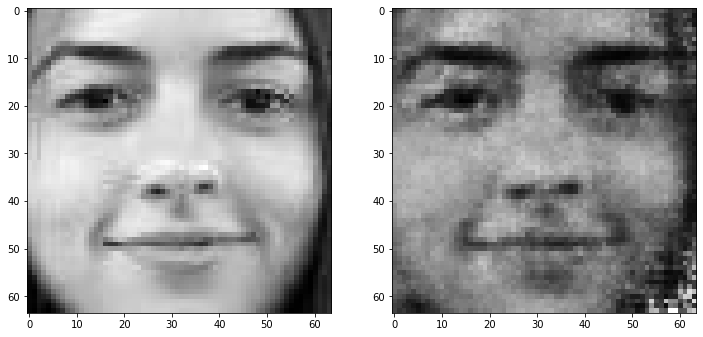

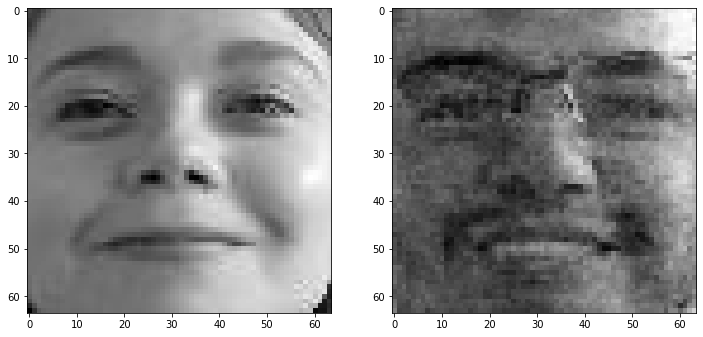

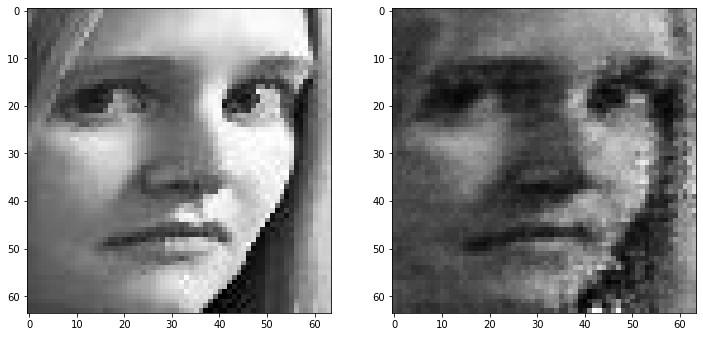

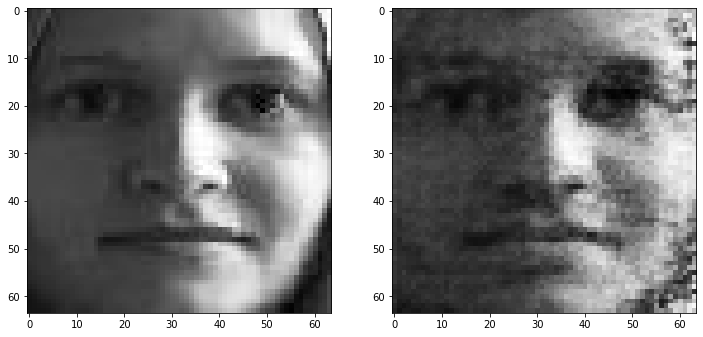

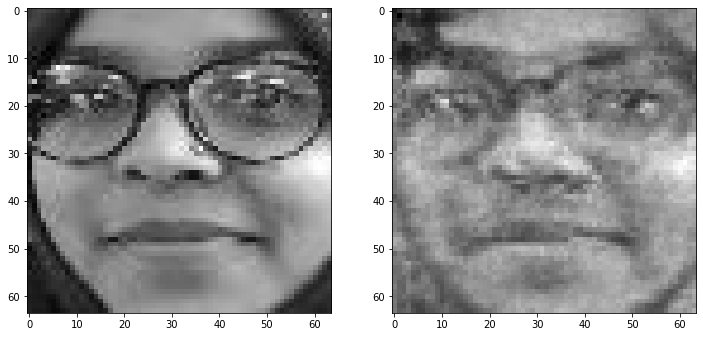

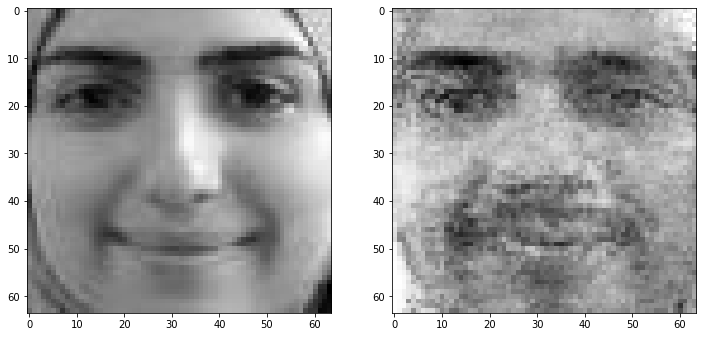

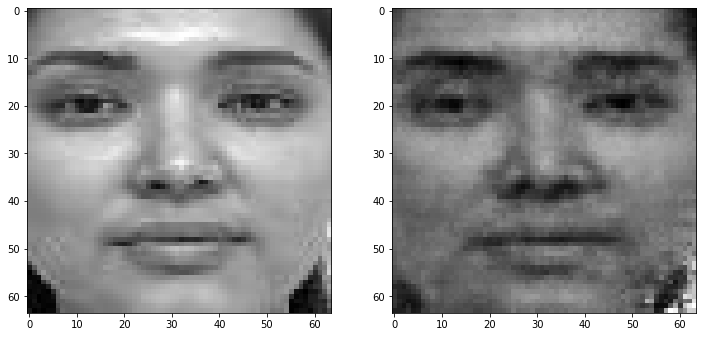

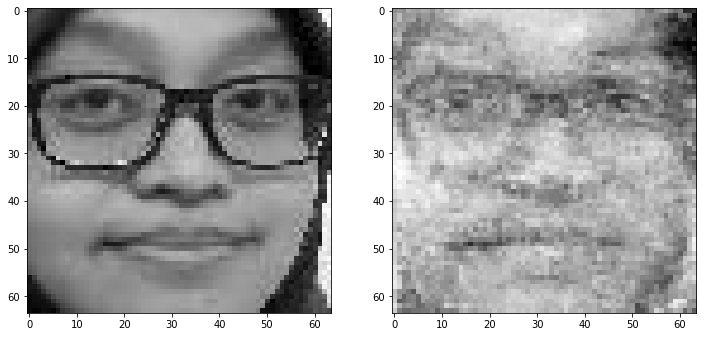

In [ ]:
import cv2
test=os.listdir(".")
for i in test:
  image = cv2.imread(i,cv2.IMREAD_GRAYSCALE)
  image = np.expand_dims(image,-1)
  test = model['G_A2B'].predict(image[np.newaxis])[0]
  test = np.squeeze(test)

  plt.figure(figsize=(12,12))
  plt.subplot(1,2,2)
  plt.imshow(test,cmap="gray")
  plt.subplot(1,2,1)
  plt.imshow(np.squeeze(image),cmap="gray")
  plt.show()
  

### Testing Model Male to Female Translation

In [ ]:
cd /content/data/malefemale/testB

/content/data/malefemale/testB


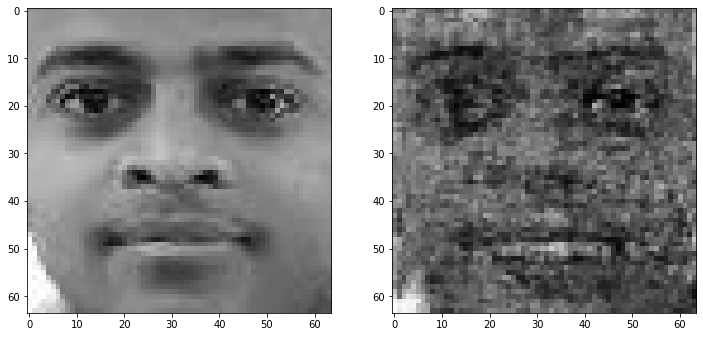

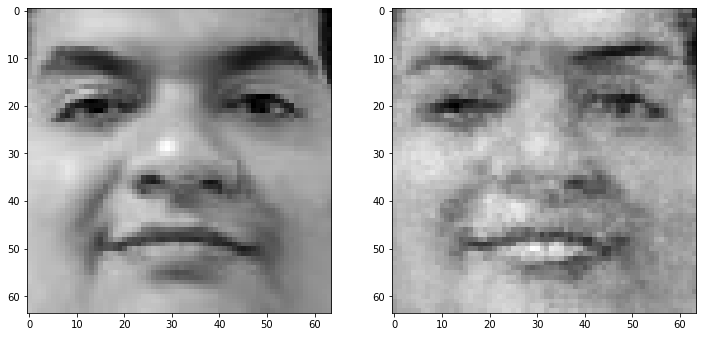

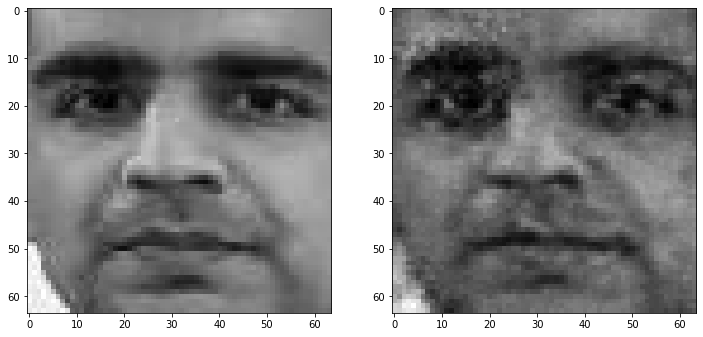

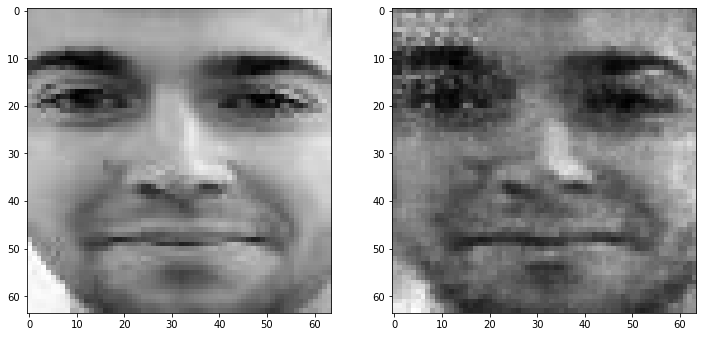

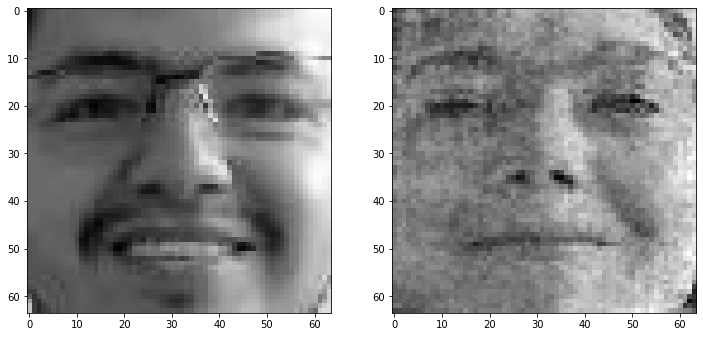

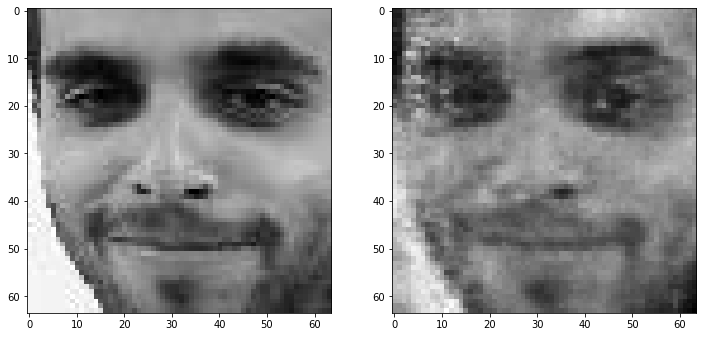

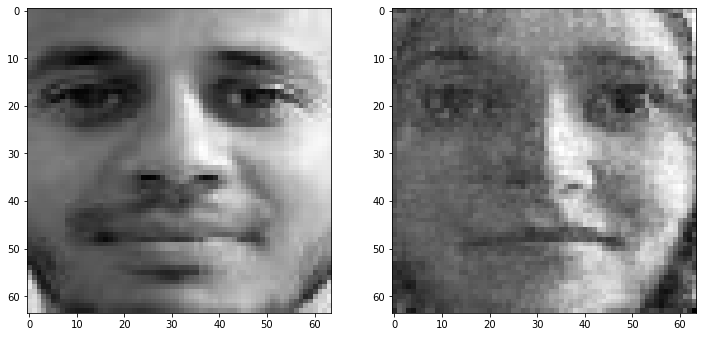

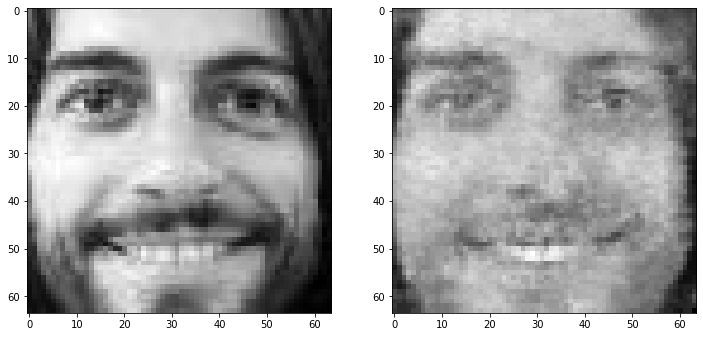

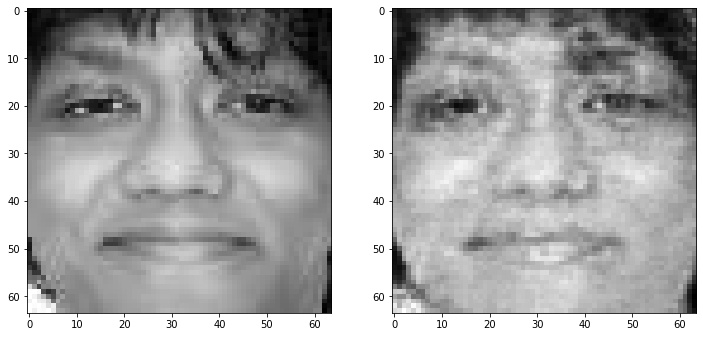

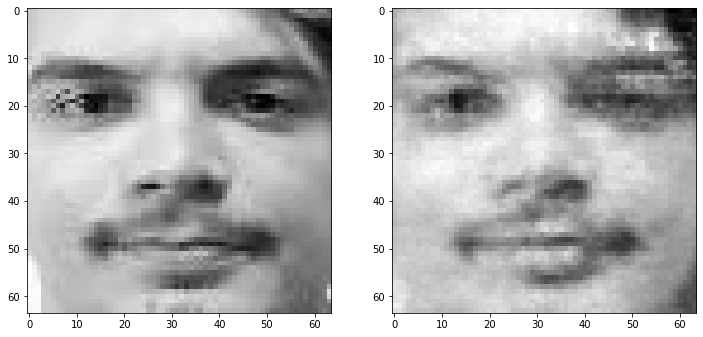

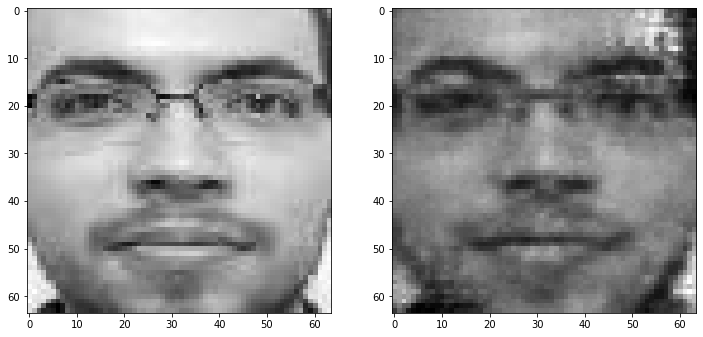

In [ ]:
import cv2
test=os.listdir(".")
for i in test:
  if i.endswith(".png"):
    image = cv2.imread(i,cv2.IMREAD_GRAYSCALE)
    image = np.expand_dims(image,-1)
    test = model['G_B2A'].predict(image[np.newaxis])[0]
    test = np.squeeze(test)

    plt.figure(figsize=(12,12))
    plt.subplot(1,2,2)
    plt.imshow(test,cmap="gray")
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(image),cmap="gray")
    plt.show()
    